# Japanese Restaurants in different New York City neighborhoods

### Import all required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

!pip install BeautifulSoup4
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

     |████████████████████████████████| 115 kB 3.4 MB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'KUKHGXJ2T4SKDTZURMZ2CBRETYGSKKQSEXNXHXBXWOW2DZB2' # Foursquare ID
CLIENT_SECRET = 'GTZUDAOI10JG2W5JLZT2GHSKKIUWYWJN2TGKIRAUZMZE3X4S' # Foursquare Secret
LIMIT = 40
VERSION = '20200719'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KUKHGXJ2T4SKDTZURMZ2CBRETYGSKKQSEXNXHXBXWOW2DZB2
CLIENT_SECRET:GTZUDAOI10JG2W5JLZT2GHSKKIUWYWJN2TGKIRAUZMZE3X4S


## Define functions to be used later 

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Analyze number and type of neighborhoods in New York City

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data = get_new_york_data()
ny_data.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [7]:
ny_data.shape

(306, 4)

So, there a total of 306 neighborhoods in New York City

## Visualize Initial Data Analysis

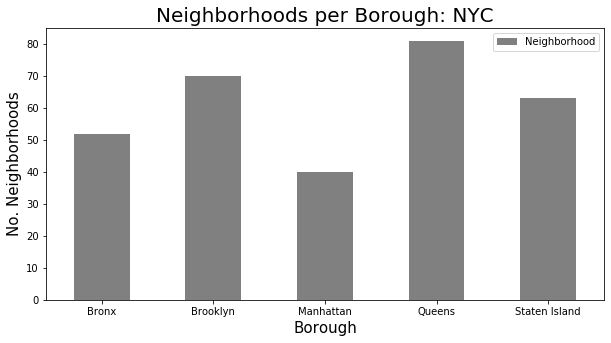

In [8]:
clr = "gray"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Queens has the most number of neighborhoods and Manhattan the least

In [14]:
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [15]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [16]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
57,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
58,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
59,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
60,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou
61,Brooklyn,Dumbo,5cf1562460255e002c5e683c,Bessou


In [17]:
japanese_rest_ny.shape

(62, 4)

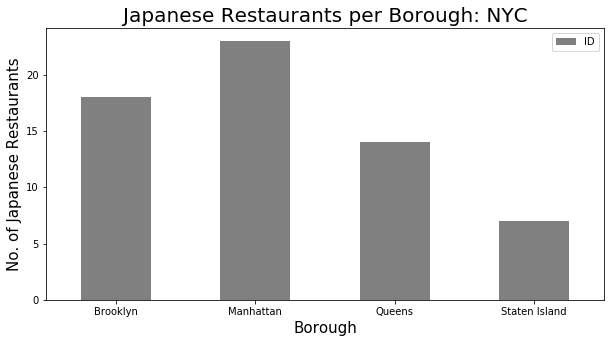

In [18]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

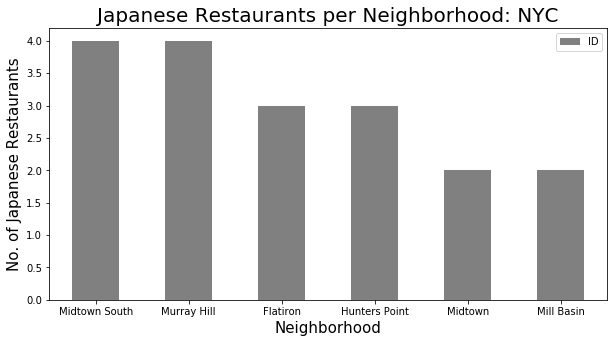

In [19]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [20]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
20,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
21,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
22,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
35,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [22]:
#Japanese restaurants with Ratings in the neighborhood
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    if count==50:
        print('Details collected for 50 rest')
        break
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f299e984c24b636cd13b1e9'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
45,Manhattan,Midtown South,51e8ce40498ea1fb0180efb2,Izakaya MEW,1055,8.7,266
46,Manhattan,Midtown South,57ab615d498eef084faa348b,Abiko Curry,132,8.3,28
47,Manhattan,Midtown South,5d7a9d59a369d40008dfcc1a,Konbini,16,8.2,2
48,Manhattan,Midtown South,58b8ed467220e661ddf34104,KazuNori: The Original Hand Roll Bar,520,9.1,125
49,Brooklyn,Mill Basin,4d7fc91f95c1a143260eecf2,Yoshi,7,7.4,7


In [23]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [24]:
japanese_rest_stats_ny.shape

(50, 7)

In [25]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [26]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [27]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.00000
mean,146.400000,7.672000,43.60000
std,227.910562,1.754067,60.91245
min,0.000000,0.000000,0.00000
25%,14.250000,7.400000,6.00000
50%,44.000000,8.200000,15.00000
75%,196.500000,8.475000,65.00000
max,1055.000000,9.200000,266.00000


In [28]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1055
Rating                               8.7
Tips                                 266
Name: 45, dtype: object

In [29]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                212
Rating                               9.2
Tips                                  62
Name: 23, dtype: object

In [30]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1055
Rating                               8.7
Tips                                 266
Name: 45, dtype: object

In [31]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
9,East Village,9.200
7,Cobble Hill,9.000
12,Fort Greene,8.800
29,North Side,8.800
30,Park Slope,8.800
1,Boerum Hill,8.800
22,Lindenwood,8.800
34,Soho,8.800
8,Downtown,8.600
26,Midtown South,8.575


In [32]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.331579
0,Brooklyn,8.253333
2,Queens,6.700000
3,Staten Island,5.885714


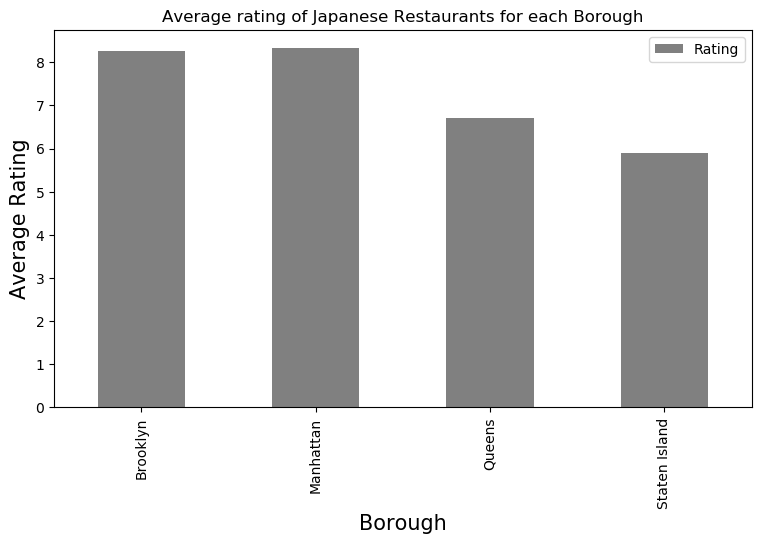

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.200
1,Boerum Hill,8.800
2,Brooklyn Heights,8.200
7,Cobble Hill,9.000
8,Downtown,8.600
9,East Village,9.200
11,Financial District,8.000
12,Fort Greene,8.800
17,Hamilton Heights,8.000
21,Lenox Hill,8.400


In [36]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.200
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.800
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.200
3,Brooklyn,Cobble Hill,40.687920,-73.998561,9.000
4,Brooklyn,Downtown,40.690844,-73.983463,8.600
5,Manhattan,East Village,40.727847,-73.982226,9.200
6,Manhattan,Financial District,40.707107,-74.010665,8.000
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.800
8,Manhattan,Hamilton Heights,40.823604,-73.949688,8.000
9,Manhattan,Lenox Hill,40.768113,-73.958860,8.400


In [37]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [38]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)